<a href="https://colab.research.google.com/github/lsiecker/Deep-Learning/blob/Task-1/assignment_2/Assignment_2_2AMM10_22_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Details

## Group Name: group21

### Student 1: N.P.G.T. van Beuningen	1353624

### Student 2: D.P.M. van der Hoorn	1873334

### Student 3: L.R. Siecker	1344838

# Loading Data and Preliminaries

In [2]:
from google.colab import drive
import io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import requests
import pickle
import sklearn.metrics as sm
import time
from tqdm.notebook import tqdm, trange

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.cuda.memory import list_gpu_processes
from torch.nn.utils.rnn import pad_sequence
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

In [3]:
base_url = "https://github.com/lsiecker/Deep-Learning/raw/main/assignment_2/data/"

In [4]:
def load_data(url, task):
    """
    Loads a numpy array from surfdrive.

    Input:
    url: Download link of dataset

    Outputs:
    dataset: numpy array with input features or labels
    """

    response = requests.get(url)
    response.raise_for_status()

    array = load_array(io.BytesIO(response.content), task)

    return array

In [5]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


In [6]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example = load_data(f"{base_url}task%201/train/trajectory_0.npz?raw=true", task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [7]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time.
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_data(f'{base_url}task%202_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_data(f'{base_url}task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


# Helper Functions Setup

In [8]:
drive.mount('/content/drive')
destination_file = '/content/drive/MyDrive/'

def save_dataset(dataset, filename):
  "Saves dataset into file on Google Drive"
  filename = destination_file + filename
  with open(filename, 'wb') as file:
     pickle.dump(dataset, file)
  print(f"Dataset saved to {filename}.")

def load_dataset(filename):
  "Loades dataset from file on Google Drive"
  filename = destination_file + filename
  with open(filename, 'rb') as file:
      dataset = pickle.load(file)
  return dataset

Mounted at /content/drive


In [9]:
class PlotTraining():
    def __init__(self):
      self.train_loss = []
      self.evaluation_loss = []
      self.test_loss = []

    def add_train(self, loss):
      self.train_loss.append(loss)

    def add_evaluation(self, loss):
      self.evaluation_loss.append(loss)

    def add_test(self, loss):
      self.test_loss.append(loss)

    def plot(self):
      fig, ax1 = plt.subplots()
      ax1.set_xlabel('epochs')
      ax1.tick_params(axis='x')
      ax2 = ax1.twinx()
      if self.train_loss is not [None] * len(self.train_loss) \
          or self.evaluation_loss is not [None] * len(self.evaluation_loss) \
          or self.test_loss is not [None] * len(self.test_loss):
        ax2.set_ylabel('loss')

      color = ["tab:blue", "tab:orange", "tab:purple", "tab:red", "tab:green", "tab:pink"]

      if self.train_loss:
        ax2.plot(list(range(len(self.train_loss))), self.train_loss, label = "Training Loss", color=color[1])
      if self.evaluation_loss:
        ax2.plot(list(range(len(self.evaluation_loss))), self.evaluation_loss, label = "Validation Loss", color=color[3])
      if self.test_loss:
        ax2.plot(list(range(len(self.test_loss))), self.test_loss, label = "Test Loss", color=color[5])

      fig.legend()
      fig.tight_layout()
      plt.locator_params(axis='x', integer=True, tight=True)
      plt.show()

In [10]:
def sequence_rotation(source_sequence):
    x = source_sequence[:, 1]
    y = source_sequence[:, 2]
    v_x = source_sequence[:, 3]
    v_y = source_sequence[:, 4]

    # Create four rotated copies of the batch of sequences
    rotated_sequences = [
        torch.stack([source_sequence[:, 0], x, y, v_x, v_y], dim=1),  # 0 degrees rotation
        torch.stack([source_sequence[:, 0], y, -x, -v_y, v_x], dim=1),  # 90 degrees rotation
        torch.stack([source_sequence[:, 0], -x, -y, -v_x, -v_y], dim=1),  # 180 degrees rotation
        torch.stack([source_sequence[:, 0], -y, x, v_y, -v_x], dim=1),  # 270 degrees rotation
    ]

    rotated_sequences_tensor = torch.stack(rotated_sequences, dim=1)  # Shape: [batch_size, 4, sequence_length, 5]

    return rotated_sequences_tensor.view(rotated_sequences_tensor.shape[0] * rotated_sequences_tensor.shape[1], 5)

def collate_batch(batch):
    """
    Concatenate multiple datapoints to obtain a single batch of data
    """
    # arrays are stored as tuples; get respective lists
    source_points = [x[0] for x in batch]
    target_points = [x[1] for x in batch]

    source_sequences = [sequence_rotation(sequence) for sequence in source_points]

    # pad sequences in batch
    source_padded = pad_sequence(sequences = source_sequences,
                             batch_first = True)
    target_padded = pad_sequence(sequences = target_points,
                             batch_first = True)

    return source_padded.to(device), target_padded.to(device)

In [134]:
def train(dataloader, log_interval, task23):

  model.train()

  start_time = time.time()
  for idx, (trajectory_points, target_points) in enumerate(tqdm(dataloader)):
        trajectory_points = trajectory_points.to(device)
        target_points = target_points.to(device)

        model.optimizer.zero_grad()
        y_pred = model(trajectory_points, target_points).narrow(dim=-1, start=1, length=2)
        if task23:
            reshaped_y_pred = y_pred.view(y_pred.shape[1], y_pred.shape[2], y_pred.shape[0], y_pred.shape[3])
            loss = model.criterion(reshaped_y_pred, target_points.narrow(dim=-1, start=0, length=2))
        else:
            loss = model.criterion(y_pred, target_points)

        loss.backward()
        model.optimizer.step()

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| loss {:8.3f}'.format(epoch, idx, len(dataloader),
                                              loss))
            start_time = time.time()

  return loss

def evaluate(dataloader, task23):
    model.eval()

    with torch.no_grad():
        for idx, (trajectory_points, target_points) in enumerate(tqdm(dataloader)):

            trajectory_points = trajectory_points.to(device)
            target_points = target_points.to(device)

            y_pred = model(trajectory_points, target_points).narrow(dim=-1, start=1, length=2)
            if task23:
                reshaped_y_pred = y_pred.view(y_pred.shape[1], y_pred.shape[2], y_pred.shape[0], y_pred.shape[3])
                loss = model.criterion(reshaped_y_pred, target_points.narrow(dim=-1, start=0, length=2))
            else:
                loss = model.criterion(y_pred, target_points)

    return loss

# Model Implementation

In [12]:
class Encoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers)

        self.dropout = nn.Dropout(dropout)

        self.double()


    def forward(self, src):
        """
        Forward pass of encoder model. It aims at
        transforming the input sentence to a dense vector
        """

        _, (hidden, cell) = self.rnn(src)

        return hidden, cell

In [92]:
class Decoder(nn.Module):
    def __init__(self, output_size, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers)

        self.fc_out = nn.Linear(hid_dim, output_size)

        self.dropout = nn.Dropout(dropout)

        self.double()


    def forward(self, input, hidden, cell):
        """
        Forward pass of the decoder model. It aims at transforming
        the dense representation of the encoder into a sequence that is
        used for position prediction
        """

        output, (hidden, cell) = self.rnn(input, (hidden, cell))

        prediction = self.dropout(self.fc_out(output))

        return prediction, hidden, cell

In [105]:
class TrainPointPredictor(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        self.criterion = nn.MSELoss()

        self.double()


    def forward(self, source_points, target_points):
        """
        Forward pass of the seq2seq model. It encodes the source sentence into
        a dense representation and thereafter transduces into the target
        sentence.

        Inputs:
        src: padded index representation of source sentences with shape [src len, batch size]
        trg:  padded index representation of target sentences with shape [trg len, batch size]

        Outputs:
        output:
        """
        batch_size = target_points.shape[0]
        trg_len = target_points.shape[1]
        trg_seq_len = source_points.shape[2]

        if len(target_points.shape) > 3:
            time_points = target_points.shape[2]
        else:
            time_points = 1

        sequence_outputs = torch.zeros(time_points, batch_size, trg_len, trg_seq_len, dtype = torch.float64).to(self.device)

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(source_points)
        input = source_points

        for t in range(0, time_points):
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states

            rnn_output, hidden, cell = self.decoder(input, hidden, cell)
            rnn_output = torch.cat((rnn_output, input[:, :, 1].unsqueeze(-1)), axis=-1)

            #place predictions in a tensor holding predictions for each token
            sequence_outputs[t] = rnn_output[:, ::4, :]
            input = rnn_output

        # output = self.decoder(input, hidden, cell)

        return sequence_outputs

# Task **1**

## Data Handling and Preprocessing

In [88]:
""" Get all training data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  train_data = load_dataset("train_data")
except:
  train_data = []
  for i in trange(0,900):
    train_data.append(load_data(f"{base_url}task%201/train/trajectory_{i}.npz?raw=true", task='task 1'))
  save_dataset(train_data, "train_data")

In [89]:
""" Get all test data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  test_data = load_dataset("test_data")
except:
  test_data = []
  for i in trange(900, 1000):
    test_data.append(load_data(f"{base_url}task%201/test/trajectory_{i}.npz?raw=true", task='task 1'))
  save_dataset(test_data, "test_data")

In [90]:
""" Create training, validation and test sets """
train_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[:800]]
val_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[800:]]

train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=5, collate_fn=collate_batch)

## Model Training

In [94]:
OUTPUT_SIZE = 4 # Length of output sequence
EMB_DIM = 5 # Length of input sequence (input for RNN layer)

# HYPERPARAMETERS TO TUNE
EPOCHS = 50 #  BEST: 50
DROPOUT = 0.2 #  BEST: 0.0
N_LAYERS = 1 # Number of RNN layers  BEST: 2
HIDDEN_DIM = 64 # Dimension of the lstm's hidden state (Embedding)  BEST: 64
LEARNING_RATE = 1e-2 #  BEST: 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

enc = Encoder(emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
dec = Decoder(output_size=OUTPUT_SIZE, emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)

model = TrainPointPredictor(enc, dec, device).to(device)
model.optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.LinearLR(model.optimizer, start_factor=1, end_factor=0.5, total_iters=EPOCHS)

train_losses, val_losses = [], []

plotter = PlotTraining()
# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss = train(train_dataloader, 500, task23 = False).cpu().detach().numpy()
    val_loss = evaluate(val_dataloader, task23 = False).cpu().detach().numpy()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    plotter.add_train(train_loss)
    plotter.add_evaluation(val_loss)

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'validation loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           train_losses[-1],
                                           val_losses[-1]))
    print('-' * 59)
    scheduler.step()
plotter.plot()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/160 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5, 9, 2])) that is different to the input size (torch.Size([1, 5, 9, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5, 8, 2])) that is different to the input size (torch.Size([1, 5, 8, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5, 7, 2])) that is different to the input size (torch.Size([1, 5, 7, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same si

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size(

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5, 6, 2])) that is different to the input size (torch.Size([1, 5, 6, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 24, 5])
torch.Size([5, 24, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size(

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
-----------------------------------------------------------
| end of epoch   1 |

  0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size(

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
-----------------------------------------------------------
| end of epoch   2 |

  0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size(

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
-----------------------------------------------------------
| end of epoch   3 |

  0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size(

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
-----------------------------------------------------------
| end of epoch   4 |

  0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size(

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
-----------------------------------------------------------
| end of epoch   5 |

  0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size(

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
-----------------------------------------------------------
| end of epoch   6 |

  0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size(

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
-----------------------------------------------------------
| end of epoch   7 |

  0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size(

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
-----------------------------------------------------------
| end of epoch   8 |

  0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size(

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
-----------------------------------------------------------
| end of epoch   9 |

  0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size(

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
-----------------------------------------------------------
| end of epoch  10 |

  0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 28, 5])
torch.Size([5, 28, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 32, 5])
torch.Size([5, 32, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 36, 5])
torch.Size([5, 36, 4])
torch.Size([5, 32, 5])
torch.Size(

KeyboardInterrupt: ignored

## Evaluation

In [63]:
test_x = [torch.tensor(array[0]) for array in test_data]
test_y = [torch.tensor(array[1]) for array in test_data]

test_x_rotations = [sequence_rotation(sequence) for sequence in test_x]

test_x_pad = pad_sequence(test_x_rotations, batch_first=True, padding_value=0)
test_y_pad = pad_sequence(test_y, batch_first=True, padding_value=0)

In [66]:
y_pred = model(test_x_pad.to(device), test_y_pad.to(device)).narrow(dim=-1, start=1, length=2).reshape(900, 2).cpu().detach().numpy()
y_test = test_y_pad.reshape(900, 2).cpu()
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))

Mean absolute error = 1.22
Mean squared error = 3.36
Median absolute error = 0.75
Explain variance score = 0.77
R2 score = 0.77


# Task **2**

## Data Handling and Preprocessing

In [129]:
""" Get all training data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  train_data = load_dataset("train_data_task23")
except:
  train_data = []
  for i in trange(0,900):
    train_data.append(load_data(f"{base_url}task%202_3/train/trajectory_{i}.npz?raw=true", task='task 2'))
  save_dataset(train_data, "train_data_task23")

In [130]:
""" Get all test data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  test_data = load_dataset("test_data_task23")
except:
  test_data = []
  for i in trange(900, 1000):
    test_data.append(load_data(f"{base_url}task%202_3/test/trajectory_{i}.npz?raw=true", task='task 2'))
  save_dataset(test_data, "test_data_task23")

In [131]:
""" Create training, validation and test sets """
train_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[:800]]
val_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[800:]]

train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=5, collate_fn=collate_batch)

## Model Training

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   1 | time: 59.79s | train loss   12.139 validation loss   16.813 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   2 | time: 59.81s | train loss   12.131 validation loss   16.785 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   3 | time: 60.22s | train loss   12.126 validation loss   16.767 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   4 | time: 60.07s | train loss   12.122 validation loss   16.752 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   5 | time: 59.81s | train loss   12.119 validation loss   16.739 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   6 | time: 59.79s | train loss   12.116 validation loss   16.727 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   7 | time: 59.82s | train loss   12.113 validation loss   16.715 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   8 | time: 59.76s | train loss   12.110 validation loss   16.705 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   9 | time: 59.73s | train loss   12.107 validation loss   16.695 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  10 | time: 59.79s | train loss   12.102 validation loss   16.685 
-----------------------------------------------------------


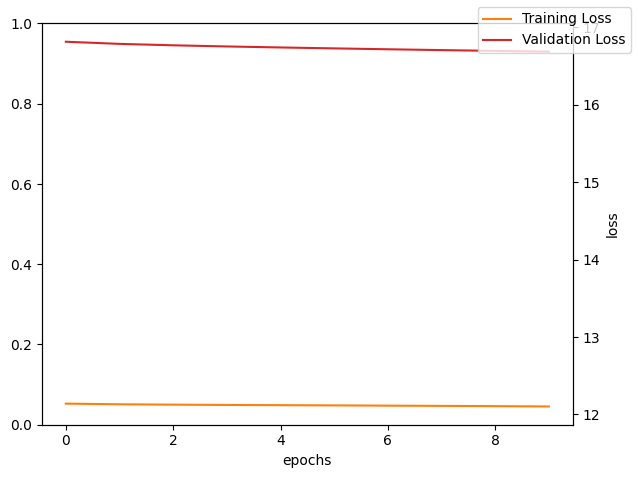

In [137]:
OUTPUT_SIZE = 4 # Length of output sequence
EMB_DIM = 5 # Length of input sequence (input for RNN layer)

# HYPERPARAMETERS TO TUNE
EPOCHS = 10 #  BEST: 100, starts overfitting afterwards
DROPOUT = 0.0 #  BEST: 0.5
N_LAYERS = 5 # Number of RNN layers  BEST: 1
HIDDEN_DIM = 128 # Dimension of the lstm's hidden state (Embedding)  BEST: 512
LEARNING_RATE = 0.1 #  BEST: 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

enc = Encoder(emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
dec = Decoder(output_size=OUTPUT_SIZE, emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)

model = TrainPointPredictor(enc, dec, device).to(device)
model.optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.LinearLR(model.optimizer, start_factor=1, end_factor=0.5, total_iters=EPOCHS)

train_loss, val_loss = [], []

plotter = PlotTraining()

# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss = train(train_dataloader, 500, task23 = True).cpu().detach().numpy()
    val_loss = evaluate(val_dataloader, task23 = True).cpu().detach().numpy()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    plotter.add_train(train_loss)
    plotter.add_evaluation(val_loss)

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'validation loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           train_losses[-1],
                                           val_losses[-1]))
    print('-' * 59)
    scheduler.step()
plotter.plot()

## Evaluation

In [138]:
test_x = [torch.tensor(array[0]) for array in test_data]
test_y = [torch.tensor(array[1]) for array in test_data]

test_x_rotations = [sequence_rotation(sequence) for sequence in test_x]

test_x_pad = pad_sequence(test_x_rotations, batch_first=True, padding_value=0)
test_y_pad = pad_sequence(test_y, batch_first=True, padding_value=0).narrow(dim=-1, start=0, length=2)

In [139]:
y_pred = model(test_x_pad.to(device), test_y_pad.to(device))
reshaped_y_pred = y_pred.view(y_pred.shape[1], y_pred.shape[2], y_pred.shape[0], y_pred.shape[3]).narrow(dim=-1, start=0, length=2).reshape(900, 98).cpu().detach().numpy()
y_test = test_y_pad.view(test_y_pad.shape[0], test_y_pad.shape[1], 49, 2).reshape(900, 98)
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, reshaped_y_pred), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, reshaped_y_pred), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, reshaped_y_pred), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test, reshaped_y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, reshaped_y_pred), 2))

Mean absolute error = 3.04
Mean squared error = 15.93
Median absolute error = 2.92
Explain variance score = -0.0
R2 score = -0.0


# Task **3**

## Data Handling and Preprocessing

In [ ]:
""" Get all training data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  train_data = load_dataset("train_data_task23")
except:
  train_data = []
  for i in trange(0,900):
    train_data.append(load_data(f"{base_url}task%202_3/train/trajectory_{i}.npz?raw=true", task='task 3'))
  save_dataset(train_data, "train_data_task23")

In [ ]:
""" Get all test data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  test_data = load_dataset("test_data_task23")
except:
  test_data = []
  for i in trange(900, 1000):
    test_data.append(load_data(f"{base_url}task%202_3/test/trajectory_{i}.npz?raw=true", task='task 3'))
  save_dataset(test_data, "test_data_task23")

In [ ]:
""" Create training, validation and test sets """
train_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[:800]]
val_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[800:]]

train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=5, collate_fn=collate_batch)

## Model Training

In [ ]:
OUTPUT_SIZE = 49*4 # Length of output sequence
EMB_DIM = 5 # Length of input sequence (input for RNN layer)

# HYPERPARAMETERS TO TUNE
EPOCHS = 100 #  BEST: 50, starts overfitting afterwards
DROPOUT = 0.5 #  BEST: 0.5
N_LAYERS = 1 # Number of RNN layers  BEST: 1
HIDDEN_DIM = 512 # Dimension of the lstm's hidden state (Embedding)  BEST: 256
LEARNING_RATE = 0.05 #  BEST: 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

enc = Encoder(emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
dec = Decoder(output_size=OUTPUT_SIZE, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)

model = TrainPointPredictor(enc, dec, device).to(device)
model.optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.LinearLR(model.optimizer, start_factor=1, end_factor=0.5, total_iters=EPOCHS)

train_loss, val_loss = [], []

plotter = PlotTraining()

# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss = train(train_dataloader, 500, task23 = True).cpu().detach().numpy()
    val_loss = evaluate(val_dataloader, task23 = True).cpu().detach().numpy()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    plotter.add_train(train_loss)
    plotter.add_evaluation(val_loss)

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'validation loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           train_losses[-1],
                                           val_losses[-1]))
    print('-' * 59)
    scheduler.step()
plotter.plot()

## Evaluation

In [ ]:
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def get_monte_carlo_predictions(data_loader,
                                forward_passes,
                                model,
                                n_classes,
                                n_samples):
    """ Function to get the monte-carlo samples and uncertainty estimates
    through multiple forward passes

    Parameters
    ----------
    data_loader : object
        data loader object from the data loader module
    forward_passes : int
        number of monte-carlo samples/forward passes
    model : object
        keras model
    n_classes : int
        number of classes in the dataset
    n_samples : int
        number of samples in the test set
    """

    dropout_predictions = np.empty((0, n_samples, n_classes))
    softmax = nn.Softmax(dim=1)
    for i in range(forward_passes):
        predictions = np.empty((0, n_classes))
        model.eval()
        enable_dropout(model)
        for i, (image, label) in enumerate(data_loader):
            image = image.to(torch.device('cuda'))
            with torch.no_grad():
                output = model(image)
                output = softmax(output)  # shape (n_samples, n_classes)
            predictions = np.vstack((predictions, output.cpu().numpy()))

        dropout_predictions = np.vstack((dropout_predictions,
                                         predictions[np.newaxis, :, :]))
        # dropout predictions - shape (forward_passes, n_samples, n_classes)

    # Calculating mean across multiple MCD forward passes
    mean = np.mean(dropout_predictions, axis=0)  # shape (n_samples, n_classes)

    # Calculating variance across multiple MCD forward passes
    variance = np.var(dropout_predictions, axis=0)  # shape (n_samples, n_classes)

    epsilon = sys.float_info.min
    # Calculating entropy across multiple MCD forward passes
    entropy = -np.sum(mean * np.log(mean + epsilon), axis=-1)  # shape (n_samples,)

    # Calculating mutual information across multiple MCD forward passes
    mutual_info = entropy - np.mean(np.sum(-dropout_predictions * np.log(dropout_predictions + epsilon),
                                           axis=-1), axis=0)  # shape (n_samples,)

In [ ]:
test_x = [torch.tensor(array[0]) for array in test_data]
test_y = [torch.tensor(array[1]) for array in test_data]

test_x_rotations = [sequence_rotation(sequence) for sequence in test_x]

test_x_pad = pad_sequence(test_x_rotations, batch_first=True, padding_value=0)
test_y_pad = pad_sequence(test_y, batch_first=True, padding_value=0).narrow(dim=-1, start=0, length=2)

In [114]:
y_pred = model(test_x_pad.to(device))
reshaped_y_pred = y_pred.view(y_pred.shape[0], y_pred.shape[1], 49, 4).narrow(dim=-1, start=0, length=2).reshape(900, 98).cpu().detach().numpy()
y_test = test_y_pad.view(test_y_pad.shape[0], test_y_pad.shape[1], 49, 2).reshape(900, 98)
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, reshaped_y_pred), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, reshaped_y_pred), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, reshaped_y_pred), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test, reshaped_y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, reshaped_y_pred), 2))

TypeError: ignored